# RIDGE RESULTS FOR ADDITIONAL ANALYSIS


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
from autoreject import LocalAutoRejectCV
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
import pickle

loc_files = "~/conincon_data/files/" # location of saved epochs
template = "{}-epo.fif" # template to load epochs

In [8]:
bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

In [9]:
names = list({fname.split("-")[0]  # list of participant IDs
              for fname in listdir(loc_files) 
              if "on_ica" in fname and fname.split("-")[0] not in bads
             })

In [10]:
# load previously calculated(and saved) scores
with open(loc_files+'scores.pckl', 'rb') as f:
        scores_dict = pickle.load(f)

In [11]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    
    epoch = mne.read_epochs(loc_files+template.format(name))
    return epoch
times = get_epochs(names[0]).times
l_times = list(times)

In [250]:
def sorted_by_pred_conf(score, tmin, tmax, tmin2, tmax2):

    '''sorts condidence scores within time window of interest'''
    
    from scipy.misc import imresize
    l_times = list(get_epochs(names[0]).times)

    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    trials = score[tmin:tmax, :, :, 0].mean(0)
    order = trials[tmin:tmax, :].mean(0).argsort()
    
    tmin3, tmax3 = l_times.index(tmin2), l_times.index(tmax2)
    trials2 = score[tmin3:tmax3, :, :, 0].mean(0)
    #output_image = imresize((trials2[:, order].T+.5), (55, 161))
    output_image = imresize((trials2[:, order].T), (55, 161))
    
    return output_image/255

In [251]:
predicts = scores_dict["ridge"]["predicts"]

In [252]:
def concat_preds(predicts, tmin, tmax):
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    trials = predicts[tmin:tmax, :, :, 0].mean(0)
    win = list(trials.T)
    w = []
    for wi in win:
        w.append(wi)
    return w
    
def get_orders(preds, tmin, tmax):
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    order = preds[:, tmin:tmax].mean(1).argsort()
    trials2 = preds[order, :]
    return trials2

In [253]:
def sorted_by_pred_conf(score, tmin, tmax, tmin2, tmax2):

    '''sorts condidence scores within time window of interest'''
    
    from scipy.misc import imresize
    l_times = list(get_epochs(names[0]).times)

    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    trials = score[tmin:tmax, :, :, 0].mean(0)
    order = trials[tmin:tmax, :].mean(0).argsort()
    
    tmin3, tmax3 = l_times.index(tmin2), l_times.index(tmax2)
    trials2 = score[tmin3:tmax3, :, :, 0].mean(0)
    #output_image = imresize((trials2[:, order].T+.5), (55, 161))
    output_image = imresize((trials2[:, order].T), (55, 161))
    
    return output_image/255

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


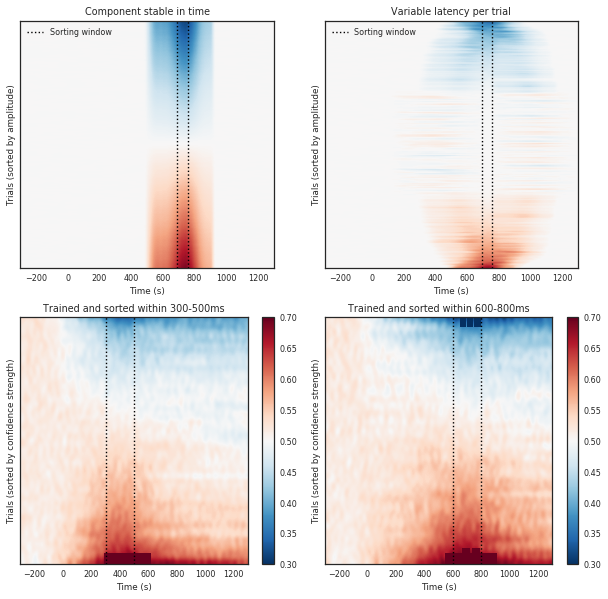

In [254]:
# trial-by-trial simulations and data for N400 and P600 data using confidence scores (i.e. distance from hyper-plane)

%matplotlib inline
from itertools import combinations

from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np

import mne
from mne.datasets import testing
from mne.channels.layout import _find_topomap_coords
from mne.stats.cluster_level import spatio_temporal_cluster_1samp_test as tst
from mpl_toolkits.axes_grid1 import make_axes_locatable



data_path = testing.data_path()
fname = "/data/home1/eheikel/mne_data/MNE-testing-data/EEGLAB/test_raw.set"
montage = "/data/home1/eheikel/mne_data/MNE-testing-data/EEGLAB/test_chans.locs"

event_id = {"rt":1, "square":2}
eog = {"FPz", "EOG1", "EOG2"}
raw = mne.io.eeglab.read_raw_eeglab(fname, preload=True, eog=eog,
                                    montage=montage, event_id=event_id
                                   ).filter(1, None)
events = mne.find_events(raw)
picks = mne.pick_types(raw.info, eeg=True)
epochs = mne.Epochs(raw, events, {"square":2, "rt": 1}, tmax=1., picks=picks, preload=True)
epochs.crop(.3, None)

d = epochs["square"].average().crop(.2, .5).data#.mean(0)
d.shape
nchans, ntimes = d.shape
#d = (d * d) * np.sign(d)

times = np.random.randint(1000, raw.n_times - 1000, 5000)

on_correlations=False


sns.set_context('paper')
fig, axes = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches((10, 10))

for ax, do_t in zip(axes.flatten()[:2], [True, False]):
    draw = raw._data.copy()

    d2 = np.array([draw[:nchans, time_-50:time_+50] for time_ in times])
    all_subjs = []
    for _ in range(40):
        draw = raw._data.copy()

        d2 = np.array([draw[:nchans, time_-50:time_+50] for time_ in times])
        ts = []
        for ii, trial in enumerate(d2):
            t = np.random.randint(25, 100-ntimes)
            ts.append(t)
            if do_t is True:
                t = np.mean((25, 100-ntimes)).astype(int)
            randn_ = np.random.uniform(-1.5, 1.5)
            d2[ii, :, t:t+ntimes] += (d * 50) * randn_#np.random.uniform(-5, 5)

        d3 = d2.mean(1)
        d3.shape

        tmean = int(np.mean(ts)) + d.mean(0).argmax()
        order = d3[:, tmean-2:tmean+2].mean(1).argsort()
        all_subjs.append(d3[order, :])
        
    d4 = np.mean(all_subjs, 0)
    #mx = np.abs(d4).max() #* .5
    mx = 0.0015
    
    
    ax.imshow(d3[order, :], aspect="auto",origin='upper', cmap="RdBu_r", interpolation="bicubic",
              extent=(-300, 1300, 0, 1), vmin=-mx, vmax=mx),
    t0, t1 = (tmean + 2) / 100, (tmean - 2) / 100
    ax.plot((t0*1600-300, t0*1600-300), (0, 1), color="k", linestyle=":", label="Sorting window") 
    ax.plot((t1*1600-300, t1*1600-300), (0, 1), color="k", linestyle=":")

    ax.set_ylabel("Trials (sorted by amplitude)")
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])
    if not on_correlations:
        ax.set_title("Component stable in time" if do_t else "Variable latency per trial")
    ax.legend()
    
    if on_correlations:

        ax_divider = make_axes_locatable(ax)
        rax = ax_divider.append_axes("top", size="20%", pad="5%")

        order = d4[:, tmean-2:tmean+2].mean(1).argsort()
        d3_ = d4[order, :]#resize(d3[order, :], (1000, 100))
        swin = d3_[:, tmean-2:tmean+3].mean(-1)
        d_ = np.array([np.corrcoef(swin, t_)[0, 1] for t_ in d3_.T])
        rax.plot(d_, label="Correlation with\nmean activity in\nsorting window")
        rax.set_xlim(0, len(d_))
        rax.set_ylim(0, 1.1)
        rax.spines['right'].set_visible(False)
        rax.spines['top'].set_visible(False)
        rax.set_ylabel("$r$")
        rax.set_xticklabels([])
        rax.set_title("Component stable in time" if do_t else "Variable latency per trial")
        rax.spines['left'].set_bounds(0, 1)
        rax.legend()
    
n1, n2, p1, p2 = .3, .5, .6, .8 

all_times = [(n1, n2, n1, n2),(p1, p2, p1, p2)]
labels= ['Trained and sorted within 300-500ms', 'Trained and sorted within 600-800ms']
for ax, tims, label in zip(axes.flatten()[2:], all_times, labels):
    d = np.asarray([sorted_by_pred_conf(p, *tims) for p in predicts])
    
    img = ax.imshow(d.mean(axis=0),origin="upper", cmap="RdBu_r",
           aspect="auto", interpolation="bicubic", extent=[-300, 1300, 0, 80],
          vmin=.3, vmax=.7);
    
    ax.set_ylabel("Trials (sorted by confidence strength)")
    ax.set_yticks([])
    ax.set_title(label)
    ax.vlines(tims[0]*1000,ymin=0, ymax=80, linestyles="dotted")
    ax.vlines(tims[1]*1000,ymin=0, ymax=80, linestyles="dotted")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(img, cax=cax)
    
    ax.set_xlabel("Time (s)")

In [229]:
fig.savefig(savsP+"sorted_sims+data.pdf")

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [255]:
scores = scores_dict["ridge"]["scores"]

In [256]:
def sorted_by_subj(scores, tmin, tmax):
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    order = scores[:, tmin:tmax].mean(1).argsort()
    trials = scores[order, :]
    return trials

In [257]:
def get_subj_lvl_dec(scores,timeN4=[0.3,0.5], timeP6=[0.6, 0.8], t1="N400", t2="P600", alpha=0.05):
    
    '''Get subject level decoders'''
    
    sub, time, accuracy, comp=[], [], [], []
    times = get_epochs(names[0]).times

    l_times = list(times)
    N4_start, N4_end = l_times.index(timeN4[0]), l_times.index(timeN4[-1]) 
    P6_start, P6_end = l_times.index(timeP6[0]), l_times.index(timeP6[-1]) 
    sigs_N4, sigs_P6 = [],[]

    df = pd.DataFrame()
    for ii, s in enumerate(scores):
        score = s.copy()
        sx=[]

        n4 = score[N4_start:N4_end].mean(axis=0)
        p6 = score[P6_start:P6_end].mean(axis=0)

        sx=[]
        for t, a in enumerate(n4):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t1), sx.append(a), 
        sigs_N4.append([sx])

        sx=[]
        for t, a in enumerate(p6):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t2), sx.append(a), 
        sigs_P6.append([sx])


    df["Time (s)"] = time
    df["Subject"] = sub
    df["Accuracy (%)"] = accuracy
    df["Component"] = comp

    return np.asarray(sigs_N4).reshape(40, 161), np.asarray(sigs_P6).reshape(40, 161)


In [258]:
dN, dP = get_subj_lvl_dec(scores)


In [259]:
def plt_subj_lvl_dec(df, times={"tmin":0.6, "tmax":0.8}, window = "P600"):
    '''plot subject level decoders'''
    
    plt.imshow(sorted_by_subj(dP, .6, .8), origin="upper", cmap="RdBu_r", 
           aspect="auto", interpolation="bicubic",
           extent=[-300, 1300, 0, 40],
          vmin=.3, vmax=.7)
    plt.vlines(0, ymin=0, ymax=40, linestyles="-")
    plt.vlines(600, ymin=0, ymax=40, linestyles="--")
    plt.vlines(800, ymin=0, ymax=40, linestyles="--")

    plt.title('Sorted P600 classifier performance by subject')
    plt.colorbar()

    return plt

In [238]:
fig.savefig(savsP+'subject-level.pdf')

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [261]:
def sorted_by_subj2(scores, tmin, tmax, tmin2, tmax2):
    score = np.asarray(scores.copy())
    tmin, tmax = l_times.index(tmin), l_times.index(tmax)
    sc = score[:,tmin:tmax].mean(1)
    order = sc[:, tmin:tmax].mean(1).argsort()

    tmin, tmax = l_times.index(tmin2), l_times.index(tmax2)
    score = score.mean(1)
    trials = score[order, :]
    return trials

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


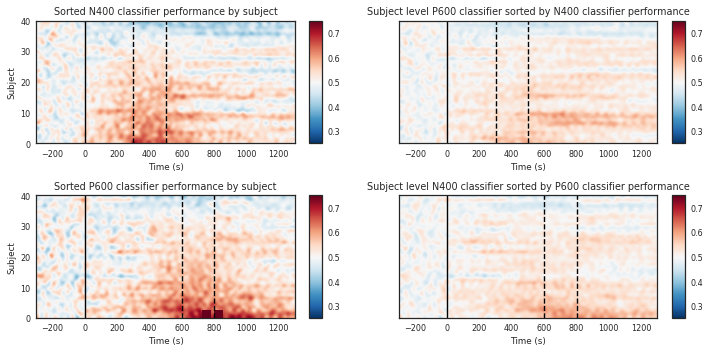

In [262]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True)
fig.set_size_inches((10, 5))
fig.set_tight_layout('tight')
time_win = [[0.3, 0.5], [0.6, 0.8]]
component = ['N400', 'P600']

dN, dP =  get_subj_lvl_dec(scores)

dt_ = [dN, dP]

# plot subject level decoder performances for N400 and P600
for ax, tim, comp, d_ in zip(axes[:, 0], time_win, component, dt_):
    img = ax.imshow(sorted_by_subj(d_, tim[0], tim[1]), origin="upper", cmap="RdBu_r", 
           aspect="auto", interpolation="bicubic",
           extent=[-300, 1300, 0, 40],
          vmin=.25, vmax=.75)
    ax.vlines(0, ymin=0, ymax=40, linestyles="-")
    ax.vlines(tim[0]*1000, ymin=0, ymax=40, linestyles="--")
    ax.vlines(tim[1]*1000, ymin=0, ymax=40, linestyles="--")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(img, cax=cax)
    ax.set_title('Sorted {} classifier performance by subject'.format(comp))
    ax.set_ylabel("Subject")
    ax.set_xlabel("Time (s)")

time_win = [[0.3, 0.5, 0.6, 0.8],[0.6, 0.8, 0.3, 0.5]]

component = [['P600','N400'],['N400', 'P600']]
#plot the subject level differces
for ax, tim,  comp, d_ in zip(axes[:, 1], time_win, component, dt_):
    img = ax.imshow(sorted_by_subj2(scores, *tim), origin="upper", cmap="RdBu_r", 
           aspect="auto", interpolation="bicubic",
           extent=[-300, 1300, 0, 40],
          vmin=.25, vmax=.75)
    ax.vlines(0, ymin=0, ymax=40, linestyles="-")
    ax.vlines(tim[0]*1000, ymin=0, ymax=40, linestyles="--")
    ax.vlines(tim[1]*1000, ymin=0, ymax=40, linestyles="--")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(img, cax=cax)
    ax.set_title('Subject level {} classifier sorted by {} classifier performance'.format(*comp))
    ax.set_xlabel("Time (s)")


In [246]:
fig.savefig(loc_files+'subject-level_final.pdf')

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


# See if different P600 time windows make a difference 

In [263]:
# statistics tests used

def _my_wilcoxon(X):
    from scipy.stats import wilcoxon
    out = wilcoxon(X)
    return out[1]

def _loop(x, function):
    out = list()
    for ii in range(x.shape[1]):
        out.append(function(x[:, ii]))
    return out

def parallel_stats(X, function=_my_wilcoxon, correction='FDR', n_jobs=-1):
    from mne.parallel import parallel_func
    import numpy as np
    from mne.stats import fdr_correction

    if correction not in [False, None, 'FDR']:
        raise ValueError('Unknown correction')
    # reshape to 2D
    X = np.array(X)
    dims = X.shape
    X.resize([dims[0], np.prod(dims[1:])])
    # prepare parallel
    n_cols = X.shape[1]
    parallel, pfunc, n_jobs = parallel_func(_loop, n_jobs)
    n_chunks = min(n_cols, n_jobs)
    chunks = np.array_split(range(n_cols), n_chunks)
    p_values = parallel(pfunc(X[:, chunk], function) for chunk in chunks)
    p_values = np.reshape(np.hstack(p_values), dims[1:])
    X.resize(dims)
    # apply correction
    if correction == 'FDR':
        dims = p_values.shape
        _, p_values = fdr_correction(p_values)
        p_values = np.reshape(p_values, dims)
    return p_values


def _stat_fun(x, sigma=0, method='relative'):
    from mne.stats import ttest_1samp_no_p
    import numpy as np
    t_values = ttest_1samp_no_p(x, sigma=sigma, method=method)
    t_values[np.isnan(t_values)] = 0
    return t_values


def stats_tfce(X, n_permutations=2**10,threshold=dict(start=.1, step=.1), n_jobs=2):
    # threshold free cluster enhancement for GATs
    import numpy as np
    from mne.stats import spatio_temporal_cluster_1samp_test

    X = np.array(X)
    T_obs_, clusters, p_values, _ = spatio_temporal_cluster_1samp_test(
    X,out_type='mask',
    stat_fun=_stat_fun,
    n_permutations=n_permutations,
    threshold=threshold,
    n_jobs=n_jobs)
    p_values = p_values.reshape(X.shape[1:])
    return p_values

In [264]:
def shape_data(scores, n4=[0.3, 0.5], p6=[0.6, 0.8]):
    
    ### Run Component Stats ###
    df1_, n4_pvalues, p6_pvalues = over_stat(scores, timeN4=n4, timeP6=p6)

    ### Test Diagonal ###
    df_diag, diag_pvalues = line_stats(scores)
    
    ### Run Difference Stats ###
    times=get_epochs(names[0]).times
    l_times = list(times)
    
    n4_start, n4_end = l_times.index(n4[0]), l_times.index(n4[1])
    p6_start, p6_end = l_times.index(p6[0]), l_times.index(p6[1])
    diff_arr = np.array([(sc[p6_start:p6_end].mean(axis=0) -
                      sc[n4_start:n4_end].mean(axis=0))
                     for sc in scores])
    
    df_diff, diff_pvalues = line_stats(diff_arr, diag=False)
    
    alpha1, alpha2 = 0.05, 0.01

    xx = np.meshgrid(get_epochs(names[0]).times)

    # identify significant time points significant decoding time points (corrected for using FDR)
    # first one (eg. n1) is p<0.05 second one (eg. n2) is p<0.01
    n1, n2  = xx[0][n4_pvalues<alpha1], xx[0][n4_pvalues<alpha2] 
    p1, p2  = xx[0][p6_pvalues<alpha1], xx[0][p6_pvalues<alpha2]
    diag1, diag2 = xx[0][diag_pvalues<alpha1], xx[0][diag_pvalues<alpha2]
    diff1, diff2 = xx[0][diff_pvalues<alpha1], xx[0][diff_pvalues<alpha2]
    
    return df1_, df_diag, df_diff, n1, n2, p1, p2, diag1, diag2, diff1, diff2

In [265]:
### Test Diagonal and Difference ###

def line_stats(scores, diag=True):
    times=get_epochs(names[0]).times
    sub, time, ac=[], [], []
    sigs3=[]
    dfN = pd.DataFrame()
    for ii, s in enumerate(scores):
        sb=ii
        acc = (list(np.diag(s)) if diag else s)
        for t, a in enumerate(acc):
            sub.append(sb), ac.append(a), time.append(times[t])
        sigs3.append([acc]) 
    dfN["Time (s)"] = time
    dfN["Subject"] = sub
    dfN["{}".format(("Accuracy (%)" if diag else "Difference in Accuracy (%)"))] = ac
    p_ = parallel_stats(np.asarray(sigs3)-(0.5 if diag else 0))[0]

    return dfN, p_

def find_clus(st2):
    '''find clusters in time for a list of time points
    '''
    clus = []
    start=st2[0]
    for ii, m in enumerate(st2):
        if ii!=0:
            if l_times.index(m)-l_times.index(st2[ii-1])>1:
                end=st2[ii-1]
                if end!=start:
                    clus.append([start, end])
                if ii!=len(st2)-1:
                    start=st2[ii]
            if ii==len(st2)-1:
                end=st2[ii]
                clus.append([round(start, 2), round(end, 2)])
    return clus

def print_clusters(one, two, testing="N400"):
        print("{} significant time points".format(testing))
        for cl in find_clus(one):
            print("0.05<p {}: {}".format(testing, cl))
        print("")
        for cl in find_clus(two):
            print("0.01<p {}: {}".format(testing, cl))
        print("")
        print("")
        print("")
        
def over_stat(scores, timeN4=[0.3,0.5], timeP6=[0.6, 0.8], t1="N400", t2="P600", alpha=0.05):
    
    """
    Function to decoder performances for specific time windows for comparison and creates DataFrame for plotting.

    Attributes:
        gats(list): List of individual GAT scores for participants.
        timeN4(list): time window 1.
        timeP6(list): time window 2.
        t1 & t2 titles for the two windows (i.e. components of interest)
    """
    
    sub, time, accuracy, comp=[], [], [], []
    times = get_epochs(names[0]).times
    
    l_times = list(times)
    N4_start, N4_end = l_times.index(timeN4[0]), l_times.index(timeN4[-1]) 
    P6_start, P6_end = l_times.index(timeP6[0]), l_times.index(timeP6[-1]) 
    sigs_N4, sigs_P6 = [],[]
    
    df = pd.DataFrame()
    for ii, s in enumerate(scores):
        score = s.copy()
        sx=[]
        n4 = score[N4_start:N4_end].mean(axis=0)
        p6 = score[P6_start:P6_end].mean(axis=0)
        
        sx=[]
        for t, a in enumerate(n4):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t1), sx.append(a), 
        sigs_N4.append([sx])

        sx=[]
        for t, a in enumerate(p6):
            sub.append(ii), accuracy.append(a), time.append(times[t]), comp.append(t2), sx.append(a), 
        sigs_P6.append([sx])


    df["Time (s)"] = time
    df["Subject"] = sub
    df["Accuracy (%)"] = accuracy
    df["Component"] = comp

    n4_pvalue = parallel_stats(np.asarray(sigs_N4)-0.5)[0]
    p6_pvalue = parallel_stats(np.asarray(sigs_P6)-0.5)[0]

    return df, n4_pvalue, p6_pvalue

def over_plot(df, axes=None):
    
    plt_ = sns.tsplot(data=df, time="Time (s)", ax=axes,
           ci=[95],  color=("green", "midnightblue"),
           unit="Subject", legend=True,
       condition="Component", value="Accuracy (%)")
    plt_.axvline(0, color="k", lw=0.5)
    plt_.axhline(0.5, color="k", lw=0.5)
    
    return plt_

In [266]:
def plot_times(scores, times_ = [[500, 700], [600, 800], [700, 900], [800, 1000], [600,1000]]):
    
    '''Plot various P600 time windows with P600 as: 500-700, 600-800 (our a priori time window), 
      700-900, 800-1000, 600-1000ms.
      
      Colour boxes index the time windows of interest (green:N400, blue:P600),
      significance lines with thin lines indexing p<0.05 and thick lines for p<0.01 (FDR corrected)'''
    
    figs, axes = plt.subplots(5, 2)
    figs.set_size_inches(15, 15)
    figs.set_tight_layout("tight")
    
    times = get_epochs(names[0]).times
    l_times = list(times)
    for t, ax in zip(times_, axes):
        # run stats on the decoders
        df1_, df_diag, df_diff, n1, n2, p1, p2, diag1, diag2, diff1, diff2 = shape_data(scores, p6=[t[0]/1000,t[1]/1000])

        # plot the component generalization
        plt_ = sns.tsplot(data=df1_, time="Time (s)", ax=ax[0],
               ci=[95],  color=("green", "midnightblue"),
               unit="Subject", legend=True,
           condition="Component", value="Accuracy (%)")

        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0.5, color="k", lw=0.5)    
        plt_.set_ylim(0.45, 0.62)

        plt_.fill_betweenx([0.45, 0.62], 0.3, 0.5, alpha=0.2, color="green")
        plt_.fill_betweenx([0.45, 0.62], t[0]/1000, t[1]/1000, alpha=0.2, color="blue")
        for clus in find_clus(n1):
            plt_.axhline(0.47, color="green", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
        for clus in find_clus(n2):
            plt_.axhline(0.47, color="green", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )

        for clus in find_clus(p1):
            plt_.axhline(0.48, color="midnightblue", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
        for clus in find_clus(p2):
            plt_.axhline(0.48, color="midnightblue", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )

        plt_.title.set_text("Component generalization for P600={}-{}ms".format(t[0], t[1]))
        plt_.axvline(0, color="k", lw=0.5)
        plt_.axhline(0.5, color="k", lw=0.5)
        plt_.tick_params("both", labelsize=10)
        plt_.title.set_fontsize(10)

        ### plot difference between decoder performance in time windows ###
        pltd_ = sns.tsplot(data=df_diff, time="Time (s)", ax=ax[1],
               ci=[95],  color="k",
               unit="Subject", condition=None,
                          value="Difference in Accuracy (%)")
        pltd_.axvline(0, color="k", lw=0.5)
        pltd_.axhline(0, color="k", lw=0.5)
        pltd_.title.set_text("Difference between N400 and P600 for {}-{}ms".format(t[0], t[1]))
        pltd_.title.set_fontsize(10)
        pltd_.set_ylim(-0.08, 0.08)

        pltd_.fill_betweenx([-0.8, 0.8], 0.3, 0.5, alpha=0.2, color="green")
        pltd_.fill_betweenx([-0.8, 0.8], t[0]/1000, t[1]/1000, alpha=0.2, color="blue")

        for clus in find_clus(diff1):
            if clus[-1] <.55:
                pltd_.axhline(-0.06, color="green", lw=1, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
            else:
                pltd_.axhline(-0.06, color="midnightblue", lw=1,  xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )


        for clus in find_clus(diff2):
            if clus[-1] <.55:
                pltd_.axhline(-0.06, color="green", lw=3, xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
            else:
                pltd_.axhline(-0.06, color="midnightblue", lw=3,  xmin=(clus[0]+0.3)/1.6, xmax=(clus[-1]+0.3)/1.6 )
        pltd_.tick_params("both", labelsize=10)

        
    return figs

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


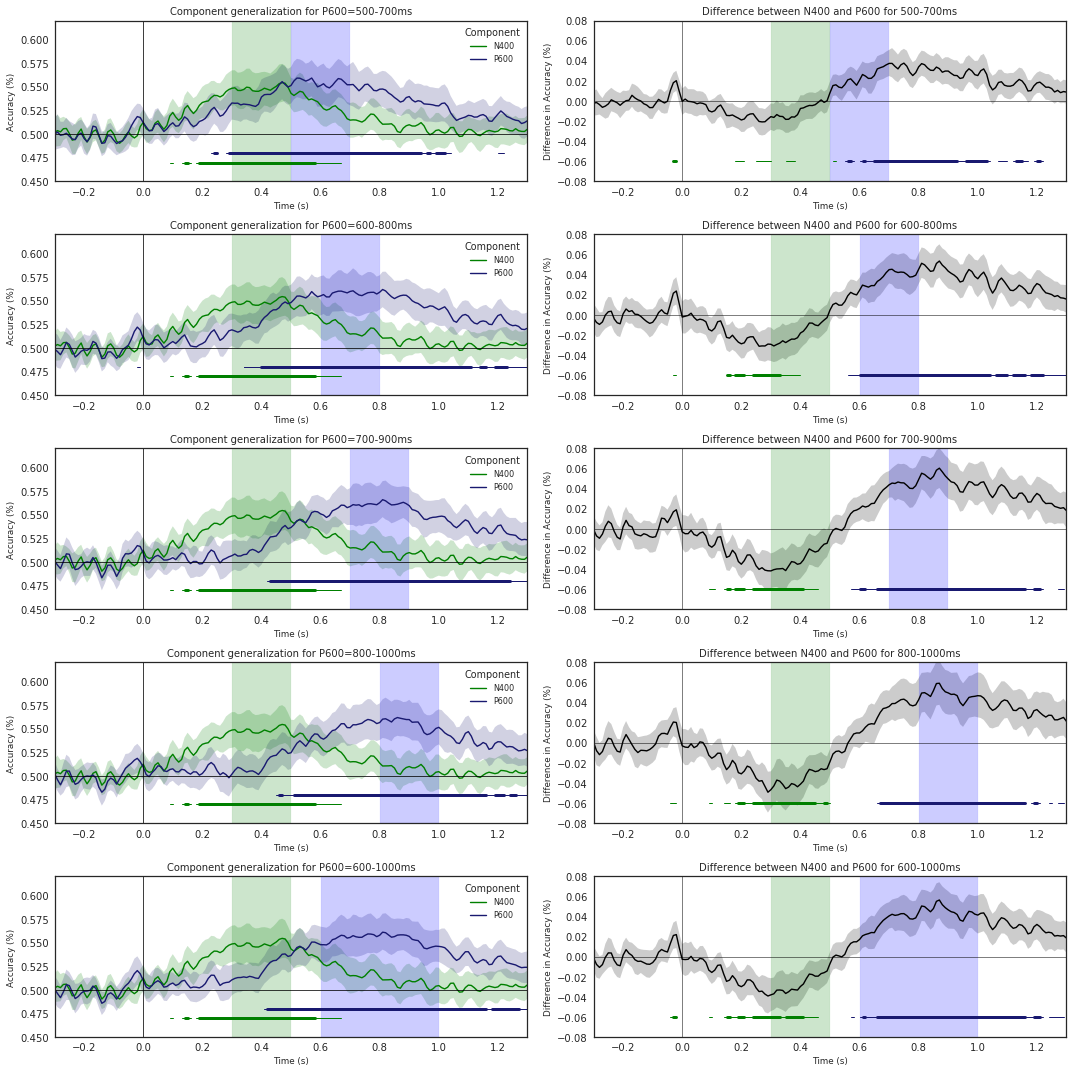

In [267]:
# test using various P600 time windows (P600 as: 500-700, 600-800 (our a priori time window), 
#                                                                         700-900, 800-1000, 600-1000ms)
dec = "ridge"
scores = scores_dict[dec]["scores"]
figs = plot_times(scores);

In [227]:
figs.savefig(loc_files+"manyt-times.pdf")

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
